## Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set()

## Import Datasets

In [2]:
url_2012 = "https://assets.datacamp.com/production/course_1550/datasets/finch_beaks_2012.csv"
file = pd.read_csv(url_2012)
df_2012=pd.DataFrame(file)
df_2012['year']=int(2012)

url_1975 = "https://assets.datacamp.com/production/course_1550/datasets/finch_beaks_1975.csv"
file = pd.read_csv(url_1975)
df_1975=pd.DataFrame(file)
df_1975['year']=int(1975)

df_1975=df_1975[df_1975['species']=='scandens']
df_2012=df_2012[df_2012['species']=='scandens']

df_1975.rename(columns={"Beak depth, mm":"beak_depth","Beak length, mm":"blength"},inplace=True)
df_2012.rename(columns={"bdepth":"beak_depth"},inplace=True)


df=pd.concat([df_1975,df_2012],axis=0)[['beak_depth','year']]
bd_1975=np.array(df_1975['beak_depth'])
bd_2012=np.array(df_2012["beak_depth"])
bl_1975=np.array(df_1975['blength'])
bl_2012=np.array(df_2012['blength'])

## Define Functions

In [3]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

In [4]:
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

In [5]:
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data,func)

    return bs_replicates

In [6]:
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    
    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    corr_mat = np.corrcoef(x,y)

In [7]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.array(len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(x))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x,bs_y,1)

    return bs_slope_reps, bs_intercept_reps

In [16]:
def draw_bs_pairs(x, y, func, size=1):
    """Perform pairs bootstrap for a single statistic."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_replicates[i] = func(bs_x,bs_y)

    return bs_replicates

## EDA of beak depths of Darwin's finches

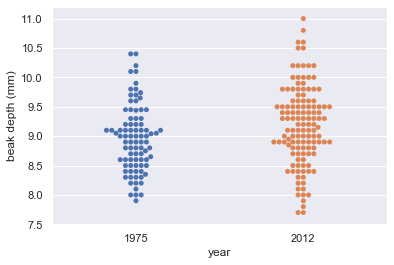

In [8]:
# Create bee swarm plot
_ = sns.swarmplot('year','beak_depth',data=df)

# Label the axes
_ = plt.xlabel('year')
_ = plt.ylabel('beak depth (mm)')

# Show the plot
plt.show()

## ECDFs of beak depths


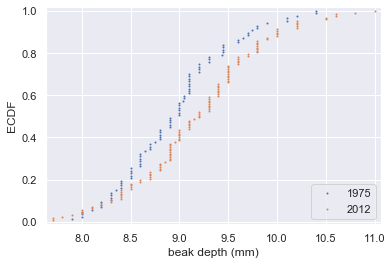

In [9]:
# Compute ECDFs
x_1975, y_1975 = ecdf(bd_1975)
x_2012, y_2012 = ecdf(bd_2012)

# Plot the ECDFs
_ = plt.plot(x_1975, y_1975, marker='.',markersize=2, linestyle='none')
_ = plt.plot(x_2012, y_2012, marker='.',markersize=2, linestyle='none')

# Set margins
plt.margins(0.02)

# Add axis labels and legend
_ = plt.xlabel('beak depth (mm)')
_ = plt.ylabel('ECDF')
_ = plt.legend(('1975', '2012'), loc='lower right')

# Show the plot
plt.show()

## Parameter estimates of beak depths


In [10]:
# Compute the difference of the sample means: mean_diff
mean_diff = np.mean(bd_2012)-np.mean(bd_1975)

# Get bootstrap replicates of means
bs_replicates_1975 = draw_bs_reps(bd_1975,np.mean,10000)
bs_replicates_2012 = draw_bs_reps(bd_2012,np.mean,10000)

# Compute samples of difference of means: bs_diff_replicates
bs_diff_replicates =bs_replicates_2012-bs_replicates_1975

# Compute 95% confidence interval: conf_int
conf_int = np.percentile(bs_diff_replicates,[2.5,97.5])

# Print the results
print('difference of means =', mean_diff, 'mm')
print('95% confidence interval =', conf_int, 'mm')

difference of means = 0.22622047244094645 mm
95% confidence interval = [0.0622545  0.39189259] mm


## Hypothesis test: Are beaks deeper in 2012?

In [11]:
# Compute mean of combined data set: combined_mean
combined_mean = np.mean(np.concatenate((bd_1975, bd_2012)))

# Shift the samples
bd_1975_shifted = bd_1975-np.mean(bd_1975)+combined_mean
bd_2012_shifted = bd_2012-np.mean(bd_2012)+combined_mean

# Get bootstrap replicates of shifted data sets
bs_replicates_1975 = draw_bs_reps(bd_1975_shifted,np.mean,10000)
bs_replicates_2012 = draw_bs_reps(bd_2012_shifted,np.mean,10000)

# Compute replicates of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_2012-bs_replicates_1975

# Compute the p-value
p = np.sum(bs_diff_replicates >= mean_diff) / len(bs_diff_replicates)

# Print p-value
print('p =', format(p,'.5f'))

p = 0.00380


## EDA of beak length and depth


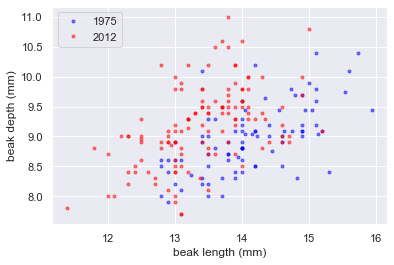

In [12]:
# Make scatter plot of 1975 data
_ = plt.plot(bl_1975,bd_1975,marker='.',
             linestyle='None', alpha=0.5, color='blue')

# Make scatter plot of 2012 data
_ = plt.plot(bl_2012,bd_2012, marker='.',
            linestyle='None', alpha=0.5, color='red')

# Label axes and make legend
_ = plt.xlabel('beak length (mm)')
_ = plt.ylabel('beak depth (mm)')
_ = plt.legend(('1975', '2012'), loc='upper left')

# Show the plot
plt.show()

## Linear regressions


In [13]:
# Compute the linear regressions
slope_1975, intercept_1975 = np.polyfit(bl_1975,bd_1975,1)
slope_2012, intercept_2012 = np.polyfit(bl_2012,bd_2012,1)
(bd_2012,bl_2012)

# Perform pairs bootstrap for the linear regressions
bs_slope_reps_1975, bs_intercept_reps_1975 = \
        draw_bs_pairs_linreg(bl_1975,bd_1975,1000)
bs_slope_reps_2012, bs_intercept_reps_2012 = \
        draw_bs_pairs_linreg(bl_2012,bd_2012,1000)

# Compute confidence intervals of slopes
slope_conf_int_1975 = np.percentile(bs_slope_reps_1975,[2.5,97.5])
slope_conf_int_2012 = np.percentile(bs_slope_reps_2012,[2.5,97.5])
intercept_conf_int_1975 = np.percentile(bs_intercept_reps_1975,[2.5,97.5])

intercept_conf_int_2012 = np.percentile(bs_intercept_reps_2012,[2.5,97.5])


# Print the results
print('1975: slope =', slope_1975,
      'conf int =', slope_conf_int_1975)
print('1975: intercept =', intercept_1975,
      'conf int =', intercept_conf_int_1975)
print('2012: slope =', slope_2012,
      'conf int =', slope_conf_int_2012)
print('2012: intercept =', intercept_2012,
      'conf int =', intercept_conf_int_2012)

1975: slope = 0.4652051691605937 conf int = [0.33835203 0.58426437]
1975: intercept = 2.3908752365842263 conf int = [0.71173288 4.15104458]
2012: slope = 0.462630358835313 conf int = [0.33420933 0.58993021]
2012: intercept = 2.9772474982360198 conf int = [1.30654262 4.70525003]


## Displaying the linear regression results


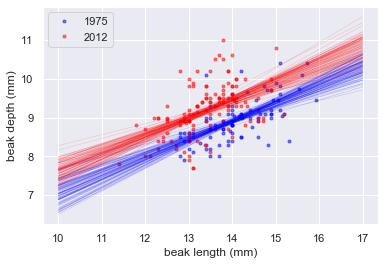

In [14]:
# Make scatter plot of 1975 data
_ = plt.plot(bl_1975, bd_1975, marker='.',
             linestyle='none', color='blue', alpha=0.5)

# Make scatter plot of 2012 data
_ = plt.plot(bl_2012, bd_2012, marker='.',
             linestyle='none', color='red', alpha=0.5)

# Label axes and make legend
_ = plt.xlabel('beak length (mm)')
_ = plt.ylabel('beak depth (mm)')
_ = plt.legend(('1975', '2012'), loc='upper left')

# Generate x-values for bootstrap lines: x
x = np.array([10, 17])
Beak length to depth ratio

# Plot the bootstrap lines
for i in range(100):
    plt.plot(x,bs_slope_reps_1975[i]*x+ bs_intercept_reps_1975[i],
             linewidth=0.5, alpha=0.2, color='blue')
    plt.plot(x,bs_slope_reps_2012[i]*x+bs_intercept_reps_2012[i],
             linewidth=0.5, alpha=0.2, color='red')

# Draw the plot again
plt.show()

## Beak length to depth ratio


In [15]:
# Compute length-to-depth ratios
ratio_1975 = bl_1975/bd_1975
ratio_2012 = bl_2012/bd_2012

# Compute means
mean_ratio_1975 = np.mean(ratio_1975)
mean_ratio_2012 = np.mean(ratio_2012)

# Generate bootstrap replicates of the means
bs_replicates_1975 = draw_bs_reps(ratio_1975,np.mean,10000)
bs_replicates_2012 = draw_bs_reps(ratio_2012,np.mean,10000)

# Compute the 99% confidence intervals
conf_int_1975 = np.percentile(bs_replicates_1975,[0.5,99.5])
conf_int_2012 = np.percentile(bs_replicates_2012,[0.5,99.5])

# Print the results
print('1975: mean ratio =', mean_ratio_1975,
      'conf int =', conf_int_1975)
print('2012: mean ratio =', mean_ratio_2012,
      'conf int =', conf_int_2012)


1975: mean ratio = 1.5788823771858533 conf int = [1.55666099 1.60068826]
2012: mean ratio = 1.4658342276847767 conf int = [1.44451984 1.48817726]


## EDA of heritability


### Make scatter plots
_ = plt.plot(bd_parent_fortis, bd_offspring_fortis,
             marker='.', linestyle='none', color='blue', alpha=0.5)
_ = plt.plot(bd_parent_scandens, bd_offspring_scandens,
             marker='.', linestyle='none', color='red', alpha=0.5)

### Label axes
_ = plt.xlabel('parental beak depth (mm)')
_ = plt.ylabel('offspring beak depth (mm)')

### Add legend
_ = plt.legend(('G. fortis', 'G. scandens'), loc='lower right')

### Show plot
plt.show()


## Pearson correlation of offspring and parental data

### Compute the Pearson correlation coefficients
r_scandens = pearson_r(bd_parent_scandens,bd_offspring_scandens)
r_fortis = pearson_r(bd_parent_fortis,bd_offspring_fortis)

### Acquire 1000 bootstrap replicates of Pearson r
bs_replicates_scandens = draw_bs_pairs(bd_parent_scandens,bd_offspring_scandens,pearson_r,1000)

bs_replicates_fortis = draw_bs_pairs(bd_parent_fortis,bd_offspring_fortis,pearson_r,1000)


### Compute 95% confidence intervals
conf_int_scandens = np.percentile(bs_replicates_scandens,[2.5,97.5])
conf_int_fortis = np.percentile(bs_replicates_fortis,[2.5,97.5])

### Print results
print('G. scandens:', r_scandens, conf_int_scandens)
print('G. fortis:', r_fortis, conf_int_fortis)


# Pearson correlation of offspring and parental data

In [ ]:
def heritability(parents, offspring):
    """Compute the heritability from parent and offspring samples."""
    covariance_matrix = np.cov(parents, offspring)
    return covariance_matrix[0,1] / covariance_matrix[0,0]

### Compute the heritability
heritability_scandens = heritability(bd_parent_scandens,bd_offspring_scandens)
heritability_fortis = heritability(bd_parent_fortis,bd_offspring_fortis)

### Acquire 1000 bootstrap replicates of heritability
replicates_scandens = draw_bs_pairs(
        bd_parent_scandens,bd_offspring_scandens, heritability, size=1000)
        
replicates_fortis = draw_bs_pairs(
        bd_parent_fortis,bd_offspring_fortis, heritability, size=1000)


### Compute 95% confidence intervals
conf_int_scandens = np.percentile(replicates_scandens,[2.5,97.5])
conf_int_fortis = np.percentile(replicates_fortis,[2.5,97.5])

### Print results
print('G. scandens:', heritability_scandens, conf_int_scandens)
print('G. fortis:', heritability_fortis, conf_int_fortis)


In [ ]:
# Initialize array of replicates: perm_replicates
perm_replicates = np.empty(10000)

# Draw replicates
for i in range(10000):
    # Permute parent beak depths
    bd_parent_permuted = np.random.permutation(bd_parent_scandens)
    perm_replicates[i] = heritability(bd_parent_permuted,
                                      bd_offspring_scandens)

# Compute p-value: p
p = np.sum(perm_replicates >= heritability_scandens) / len(perm_replicates)

# Print the p-value
print('p-val =', p)
